-- PROGRAMMING FOR DATA ANALYTICS : ADABOOST__


__Author    : Clyde Watts__  
__Lecturere : Andrew Beaty__  
__Date      : 2025-11-20__



__What is ADABOOST__

Adaboost is part of the family of ensemble models , like random forest and xgboost , except that this model is serial and not paralell like random forest and xgboost. It uses a strategy of each model tries and correct the error of the previous model. In regression which is what this project does , the model adjusts based on the predicted error.  The Adaboost has similar performance to Random Forest. In the testing it appeared 


[AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)   
[Solar Irradiation Forecasting Using Ensemble Voting Based on Machine Learning Algorithms](https://www.mdpi.com/2071-1050/15/10/7943)   
()[https://www.mdpi.com/2071-1050/11/5/1501]   
(Machine Learning-Based Approaches for Solar Energy Forecasting)[https://www.preprints.org/manuscript/202503.1637]   

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
# xlrd is required for reading xls Excel files
# Use this when displaying markdown in Jupyter Notebooks ( Gemini suggestion )
from IPython.display import display, Markdown
# do AdaBoost regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Configure File Paths and Solar Parameters

Sets up the directory paths for data and models used throughout the analysis:
- Determines the notebook's current directory
- Defines paths to training, testing, and processed data
- Configures solar panel parameters (19 panels, 8,360W total capacity)
- Sets location coordinates for Bettystown, Ireland


In [81]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
TRAIN_DATA_DIR = f'{DATA_DIR}/training_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
BACKUP_FILE_TYPE = 'feather'  # Options: 'csv', 'feather', 'parquet'
# Plotly setup
plt.style.use('classic')
sns.set_style('whitegrid')
# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 12
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


## Set Nighttime Threshold

Filters out nighttime data where Clear Sky GHI ≤ 50 W/m². 

Only daytime data with meaningful solar radiation is used for training the model.


In [82]:
hourly_nightly_threshold = 50

# AdaBoost Regression Analysis Of Solar and Weather

[AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)

In [83]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Define Data File Paths

Specifies the file paths for:
- Enriched features dataset with Copernicus weather data
- Weather data from multiple sources
- Training and testing datasets split by date


In [84]:
file_enriched_features = "data/processed_data/hourly_solar_copernicus_enriched_data.feather"
file_weather_data = "data/processed_data/hourly_weather_data.feather"
file_solar_data="data/processed_data/daily_solar_data.feather"
file_training_data = f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather"
file_testing_data = f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather"


__Load Test and Training Data_


In [85]:
df_daytime_train = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather")
df_daytime_test = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather")

# use list comprehension to get list of columns for level 1 and level 2 from weather data
# level 1 and levl 2 are based on condition codes from meteostat - it onehot encoding of weather conditions , with level 1 lowest level , and level 2 a summary level
level1_features = [level for level in df_daytime_train.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_daytime_train.columns.tolist() if level.startswith('level2_')]

## Display Dataset Structure

Shows the column names and data types of the training dataset to verify the data loaded correctly.


In [86]:
# display column list and data types and index
display(pd.DataFrame({"Columns": df_daytime_train.columns, "Data Types": df_daytime_train.dtypes}))


,Columns,Data Types
index,index,int64
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
...,...,...
Hour,Hour,int32
Clearsky_Index,Clearsky_Index,float64
PV(W)_error,PV(W)_error,float64
PV(W)_error_index,PV(W)_error_index,float64


## Histogram of various solar measures 

This shows a histogram of the various measures solar output. 

In [279]:

feature_cols = []
# Columns: ['index', 'DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)', 'WeekOfYear', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
feature_cols = []
test_no="999"
# Define target column

#target_col = 'PV(W)'
#target_col = 'Clearsky_Index'
target_col = 'PV(W)_error'
#target_col = 'PV(W)_error_index'
#
test_name=f"Optimal Features  No Level 2 and No Clearsky - Target {target_col}"
notes="This is the best combination of features exclude level 2 and no clearsky weather features"

# Put change here to add more features
feature_cols.append('Temperature(C)')
feature_cols.append('Humidity(%)')
#feature_cols.append('Sunshine Duration')
#feature_cols.append('Condition Code')
feature_cols.append('Precipitation(mm)')
feature_cols.append('Dew Point(C)')
feature_cols.append('Wind Direction(deg)')
feature_cols.append('Wind Speed(m/s)')
#feature_cols.append('Wind Gust(m/s)')
feature_cols.append('Pressure(hPa)')
#feature_cols.append('Snow Depth(cm)')
#feature_cols.append('Wind Cooling')
#  level1_features
#feature_cols.append('# Observation period')
#feature_cols.append('TOA')
#feature_cols.append('Clear sky GHI')
#feature_cols.append('Clear sky BHI')
#feature_cols.append('Clear sky DHI')
#feature_cols.append('Clear sky BNI')
# Relate to target #feature_cols.append('GHI')
# Relate to target #feature_cols.append('BHI')
# Relate to target #feature_cols.append('DHI')
# Relate to target #feature_cols.append('BNI')
# String ignore feature_cols.append('Reliability,')
# Relate to target #feature_cols.append('POA_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POA_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('Power_Pane_I(W)')
# Relate to target #feature_cols.append('Power_Pane_II(W)')
#feature_cols.append('Power_ClearSky_Pane_I(W)')
#feature_cols.append('Power_ClearSky_Pane_II(W)')
# Relate to target #feature_cols.append('Total_Power_Output(W)')
feature_cols.append('Total_Power_ClearSky_Output(W)')
#feature_cols.append('WeekOfYear')
feature_cols.append('Month_Sin')
feature_cols.append('DayOfYear_Sin')
feature_cols.append('HourOfDay_Sin')
#feature_cols.append('Month_Cos')
#feature_cols.append('DayOfYear_Cos')
#feature_cols.append('HourOfDay_Cos')


feature_cols.append('Dew Point(C)_Lag1')
feature_cols.append('Temp_Lag1')
feature_cols.append('Humidity_Lag1')
feature_cols.append('WindSpeed_Lag1')
#feature_cols.append('Dew Point(C)_Lag24')
#feature_cols.append('Temp_Lag24')
#feature_cols.append('Humidity_Lag24')
#feature_cols.append('WindSpeed_Lag24')
feature_cols.append('Total_Power_ClearSky_Output(W)_Lag1')
#feature_cols.append('Total_Power_ClearSky_Output(W)_Lag24')
# Wind direction as sin and cos
#feature_cols.append('WindDir_Sin')
#feature_cols.append('WindDir_Cos')
#  level2_features
#feature_cols += level2_features
#  level1_features
feature_cols += level1_features

print(f"\nTesting AdaBoost Regressor with target: {target_col} and features: {feature_cols}")



Testing AdaBoost Regressor with target: PV(W)_error and features: ['Temperature(C)', 'Humidity(%)', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Pressure(hPa)', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'Dew Point(C)_Lag1', 'Temp_Lag1', 'Humidity_Lag1', 'WindSpeed_Lag1', 'Total_Power_ClearSky_Output(W)_Lag1', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm']


## Prepare Training and Testing Data

Creates the feature matrices (X) and target vectors (y) for both training and testing datasets.

Splits the data into independent variables (features) and dependent variable (target) for model training and evaluation.


In [280]:

print(f"\nTesting AdaBoost Regressor with target: {target_col} and features: {feature_cols}")
# Create x and y for training and testing
X_train = df_daytime_train[feature_cols]
y_train = df_daytime_train[target_col]
X_test = df_daytime_test[feature_cols]
y_test = df_daytime_test[target_col]
# print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)




Testing AdaBoost Regressor with target: PV(W)_error and features: ['Temperature(C)', 'Humidity(%)', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Pressure(hPa)', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'Dew Point(C)_Lag1', 'Temp_Lag1', 'Humidity_Lag1', 'WindSpeed_Lag1', 'Total_Power_ClearSky_Output(W)_Lag1', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm']
X_train shape: (2192, 31)
y_train shape: (2192,)
X_test shape: (2194, 31)
y_test shape: (2194,)


__Finding the best hyperparameters__

Optuna is a library the tunes the hyper perameters of variaous models .   
(OPTUNA : hyperparameter optimization framework)[https://optuna.org/]

In [222]:
import optuna
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

def objective(trial):
    # --- 1. AdaBoost Specific Params ---
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0, log=True)
    # NEW: Try different ways of calculating error
    loss = trial.suggest_categorical('loss', ['linear', 'square', 'exponential'])

    # --- 2. Base Estimator (Decision Tree) Params ---
    max_depth = trial.suggest_int('max_depth', 1, 10)
    # NEW: Control how detailed the trees are allowed to get
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # --- 3. Setup Model ---
    DTR = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    model = AdaBoostRegressor(
        estimator=DTR, 
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        loss=loss, 
        random_state=42
    )
    
    # --- 4. Train and Evaluate ---
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)

[I 2026-01-06 20:46:04,657] A new study created in memory with name: no-name-245b3a37-d04a-4e77-b6b3-80be3d2b285f
[I 2026-01-06 20:46:09,162] Trial 0 finished with value: 0.2221903354603336 and parameters: {'n_estimators': 888, 'learning_rate': 0.006711660537500006, 'loss': 'square', 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.2221903354603336.
[I 2026-01-06 20:46:16,892] Trial 1 finished with value: 0.2107435392738605 and parameters: {'n_estimators': 660, 'learning_rate': 0.0015299638531332935, 'loss': 'exponential', 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.2107435392738605.
[I 2026-01-06 20:46:22,409] Trial 2 finished with value: 0.20214491233481524 and parameters: {'n_estimators': 512, 'learning_rate': 0.04107542082428946, 'loss': 'square', 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.20214491233481524.
[I 2026-01-06 20:46:22,989

Best params: {'n_estimators': 694, 'learning_rate': 0.9409585775702958, 'loss': 'square', 'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 5}


## Initialize AdaBoost Model with Optimized Hyperparameters

Creates an AdaBoost Regressor with the best hyperparameters found through optimization:
- **Base estimator**: Decision tree with limited depth to prevent overfitting
- **n_estimators**: Number of boosting iterations
- **learning_rate**: Weight applied to each regressor at each iteration

AdaBoost combines multiple weak learners to create a strong predictive model.


In [281]:
# Initialize AdaBoost Regressor with optimized hyperparameters
# Base estimator: Decision tree with limited depth to prevent overfitting
# n_estimators: Number of boosting iterations
# learning_rate: Weight applied to each regressor at each boosting iteration
base_estimator = DecisionTreeRegressor(max_depth=9,
                                        min_samples_split=11,
                                        min_samples_leaf=5,
                                        random_state=42)

ada_model = AdaBoostRegressor(
    estimator=base_estimator,
    n_estimators=1000, # number of estimators
    learning_rate=0.001, # reduce to improve learning rate but prevent overfit
    random_state=42,
    loss='square' # use linear loss function, other options: 'square', 'exponential' - uses squared if there are outliers
)

# Train the model
ada_model.fit(X_train, y_train)

# Make predictions
y_train_pred = ada_model.predict(X_train)
y_test_pred = ada_model.predict(X_test)

if target_col in ['PV(W)']:
    y_train_pvw_pred = y_train_pred
    y_train_pvw = y_train
    y_test_pvw_pred = y_test_pred
    y_test_pvw = y_test
elif target_col in ['PV(W)_error']:
    y_train_pvw_pred = y_train_pred + X_train['Total_Power_ClearSky_Output(W)']
    y_train_pvw = y_train + X_train['Total_Power_ClearSky_Output(W)']
    y_test_pvw_pred = y_test_pred + X_test['Total_Power_ClearSky_Output(W)']
    y_test_pvw = y_test + X_test['Total_Power_ClearSky_Output(W)']
if target_col in ['Clearsky_Index']:    
    y_train_pvw_pred = y_train_pred * X_train['Total_Power_ClearSky_Output(W)']
    y_train_pvw = y_train * X_train['Total_Power_ClearSky_Output(W)']
    y_test_pvw_pred = y_test_pred * X_test['Total_Power_ClearSky_Output(W)']
    y_test_pvw = y_test * X_test['Total_Power_ClearSky_Output(W)']
elif target_col in ['PV(W)_error_index']:
    y_train_pvw_pred = (y_train_pred * X_train['Total_Power_ClearSky_Output(W)']) + X_train['Total_Power_ClearSky_Output(W)']
    y_train_pvw = (y_train * X_train['Total_Power_ClearSky_Output(W)']) + X_train['Total_Power_ClearSky_Output(W)']
    y_test_pvw_pred = (y_test_pred * X_test['Total_Power_ClearSky_Output(W)']) + X_test['Total_Power_ClearSky_Output(W)']
    y_test_pvw = (y_test * X_test['Total_Power_ClearSky_Output(W)']) + X_test['Total_Power_ClearSky_Output(W)']

In [282]:
# generate 3 main metrics: RMSE, MAE, R2 for both training and testing
# # do XBOOST regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score


# do XBOOST regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    # and normalized based on MAX of y_true - the standard practice for solar prediction
    normalization_factor = np.max(y_true) - np.min(y_true)
    #normalization_factor = 8400 # based on max PV(W) based on system size
    n_rmse = rmse / normalization_factor
    n_mae = mae / normalization_factor
    # calculate accuracy as 1 - (mae / mean of y_true)
    accuracy_score = 1 - (mae / np.mean(y_true))
    # Calculate Explained Variance
    explained_var = explained_variance_score(y_true, y_pred)
    return rmse, mae, r2 , n_rmse, n_mae, accuracy_score, explained_var
train_rmse, train_mae, train_r2, train_n_rmse, train_n_mae, train_accuracy, train_explained_var = calculate_metrics(y_train, y_train_pred)
test_rmse, test_mae, test_r2, test_n_rmse, test_n_mae, test_accuracy, test_explained_var = calculate_metrics(y_test, y_test_pred)
train_rmse_pvw, train_mae_pvw, train_r2_pvw, train_n_rmse_pvw, train_n_mae_pvw, train_accuracy_pvw, train_explained_var_pvw = calculate_metrics(y_train_pvw, y_train_pvw_pred)
test_rmse_pvw, test_mae_pvw, test_r2_pvw, test_n_rmse_pvw, test_n_mae_pvw, test_accuracy_pvw, test_explained_var_pvw = calculate_metrics(y_test_pvw, y_test_pvw_pred)
# print the metrics , output into a markdown table , include percentages for n_rmse and n_mae and accuracy
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |
| Explained Variance | {:.4f}         | {:.4f}              |
""".format(
    train_rmse, test_rmse,
    train_mae, test_mae,
    train_r2, test_r2,
    train_n_rmse*100, test_n_rmse*100,
    train_n_mae*100, test_n_mae*100,
    train_accuracy*100, test_accuracy*100,
    train_explained_var, test_explained_var
)
from IPython.display import display, Markdown
display(Markdown(f"### XBOOST Regressor Performance Metrics {target_col}\n" + mk_string))
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |
| Explained Variance | {:.4f}         | {:.4f}              |
""".format(
    train_rmse_pvw, test_rmse_pvw,
    train_mae_pvw, test_mae_pvw,
    train_r2_pvw, test_r2_pvw,
    train_n_rmse_pvw*100, test_n_rmse_pvw*100,
    train_n_mae_pvw*100, test_n_mae_pvw*100,
    train_accuracy_pvw*100, test_accuracy_pvw*100,
    train_explained_var_pvw, test_explained_var_pvw
)
from IPython.display import display, Markdown
display(Markdown(f"### XBOOST Regressor Performance Metrics PV(W)\n" + mk_string))

### XBOOST Regressor Performance Metrics PV(W)_error
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 341.25              | 680.11              |
| MAE          | 245.20              | 480.05              |
| R2           | 0.9155              | 0.6209              |
| N-RMSE (%)   | 5.5234              | 10.8140              |
| N-MAE (%)    | 3.9688              | 7.6329              |
| Accuracy (%) | 116.1505              | 134.1015              |
| Explained Variance | 0.9155         | 0.6211              |


### XBOOST Regressor Performance Metrics PV(W)
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 341.25              | 680.11              |
| MAE          | 245.20              | 480.05              |
| R2           | 0.9424              | 0.7586              |
| N-RMSE (%)   | 6.0733              | 12.1306              |
| N-MAE (%)    | 4.3639              | 8.5622              |
| Accuracy (%) | 86.1218              | 74.8054              |
| Explained Variance | 0.9424         | 0.7587              |


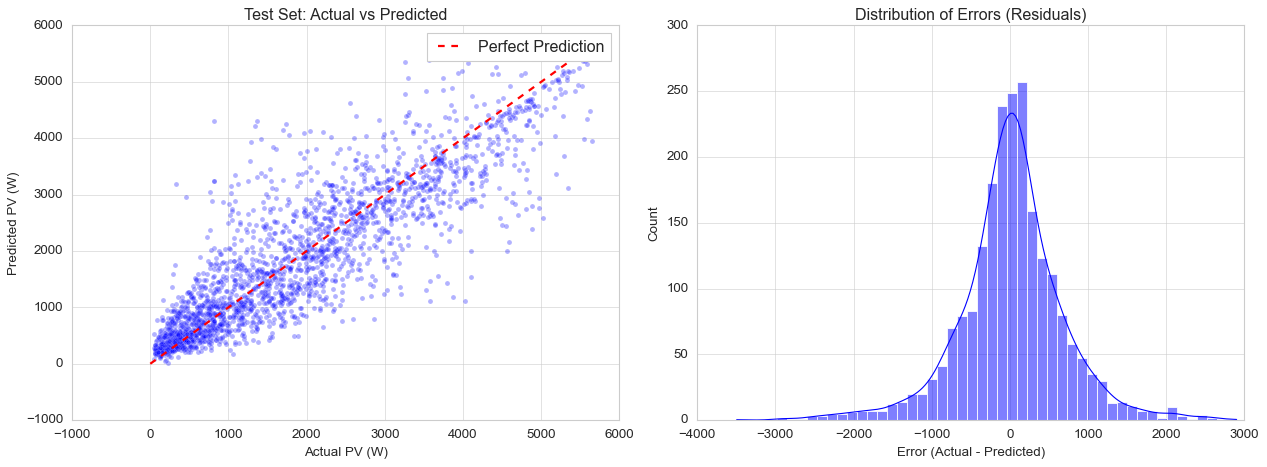

In [283]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter plot of Actual vs Predicted
sns.scatterplot(x=y_test_pvw, y=y_test_pvw_pred, alpha=0.3, ax=ax[0])
# Add a diagonal red line (Perfect Prediction)
max_val = max(y_test_pvw.max(), y_test_pvw_pred.max())
ax[0].plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
ax[0].set_xlabel('Actual PV (W)')
ax[0].set_ylabel('Predicted PV (W)')
ax[0].set_title('Test Set: Actual vs Predicted')
ax[0].legend()

# Plot 2: Residuals (Errors) over time or distribution
residuals = y_test_pvw - y_test_pvw_pred
sns.histplot(residuals, kde=True, ax=ax[1], bins=50)
ax[1].set_xlabel('Error (Actual - Predicted)')
ax[1].set_title('Distribution of Errors (Residuals)')

plt.tight_layout()
plt.show()

__Metrics for Tests 

In [284]:
# feature importance plot
importances = ada_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(20))


                                Feature  Importance
7        Total_Power_ClearSky_Output(W)    0.434967
1                           Humidity(%)    0.162951
25                      level1_overcast    0.064912
4                   Wind Direction(deg)    0.062607
15  Total_Power_ClearSky_Output(W)_Lag1    0.033447
13                        Humidity_Lag1    0.031597
6                         Pressure(hPa)    0.030082
17                        level1_cloudy    0.022114
10                        HourOfDay_Sin    0.020579
2                     Precipitation(mm)    0.019608
9                         DayOfYear_Sin    0.018782
3                          Dew Point(C)    0.011480
24                    level1_light_rain    0.011158
16                         level1_clear    0.011101
12                            Temp_Lag1    0.010963
0                        Temperature(C)    0.010831
11                    Dew Point(C)_Lag1    0.010747
5                       Wind Speed(m/s)    0.009757
14          

## Visualize Feature Importance

Creates a bar plot showing the top 20 most important features for the AdaBoost model.

Feature importance helps understand which variables have the strongest influence on solar power predictions.


C:\Users\cw171001\AppData\Local\Temp\ipykernel_22200\1129435696.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')


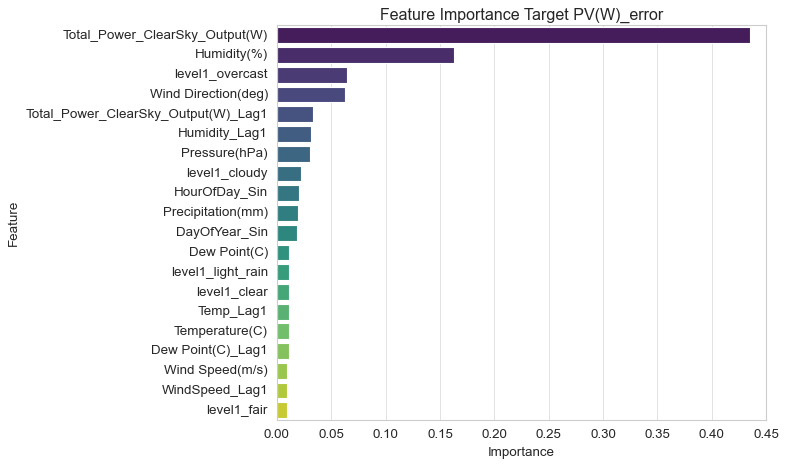

In [285]:

plt.figure(figsize=(10, 6))
plt.title(f'Feature Importance Target {target_col}')
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## Plot Prediction Residuals

Visualizes the residuals (prediction errors) for both training and testing datasets:
- Scatter plot of residuals vs actual values
- Helps identify patterns in prediction errors
- Residuals should be randomly distributed around zero for a good model


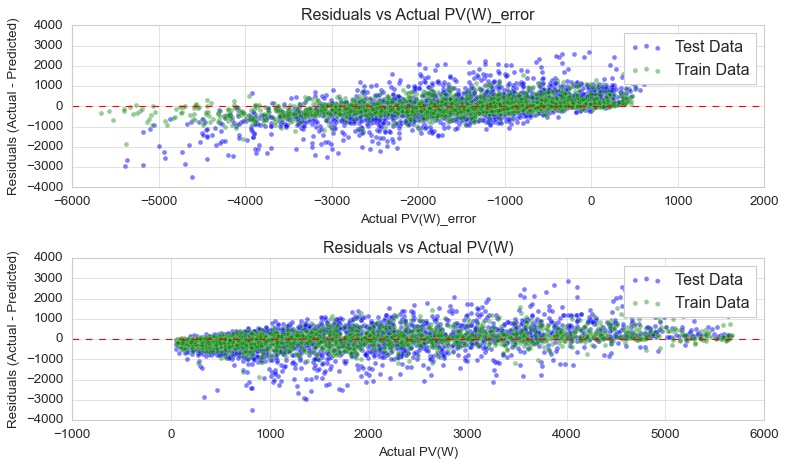

In [286]:
# plot residuals
#import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1,figsize=(10,6))
ax = ax.flatten()

# use sns scatter plot to show residuals
sns.set_style("whitegrid")
sns.scatterplot(x=y_test, y=y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5 ,ax=ax[0])
sns.scatterplot(x=y_train, y=y_train - y_train_pred, color='green', label='Train Data', alpha=0.4, ax=ax[0])
ax[0].axhline(y=0, color='red', linestyle='--')
ax[0].set_title(f'Residuals vs Actual {target_col}')
ax[0].set_xlabel(f'Actual {target_col}')
ax[0].set_ylabel('Residuals (Actual - Predicted)')
ax[0].legend()

# use sns scatter plot to show residuals
sns.set_style("whitegrid")
sns.scatterplot(x=y_test_pvw, y=y_test_pvw - y_test_pvw_pred, color='blue', label='Test Data', alpha=0.5 ,ax=ax[1])
sns.scatterplot(x=y_train_pvw, y=y_train_pvw - y_train_pvw_pred, color='green', label='Train Data', alpha=0.4, ax=ax[1])
ax[1].axhline(y=0, color='red', linestyle='--')
ax[1].set_title(f'Residuals vs Actual PV(W)')
ax[1].set_xlabel(f'Actual PV(W)')
ax[1].set_ylabel('Residuals (Actual - Predicted)')
ax[1].legend()
plt.tight_layout()
plt.show()




## Analyze Residuals by Hour of Day

Plots residuals against the hour of day to check for time-based patterns in prediction errors.

This helps identify if the model performs differently at certain times of the day.


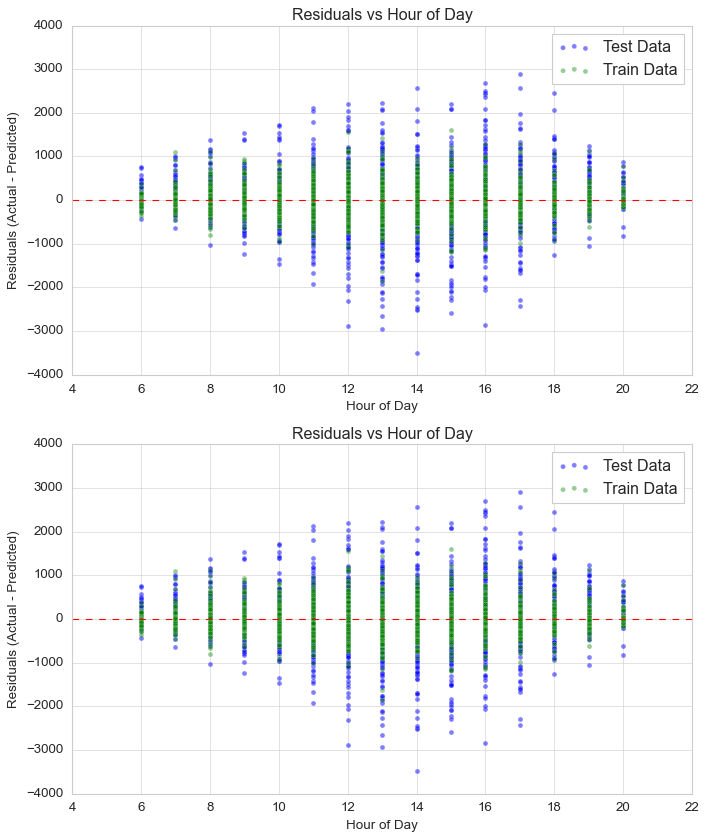

In [287]:
# plot risduals per hour of day
fig, ax = plt.subplots(2,1,figsize=(10,12))
ax = ax.flatten()
sns.scatterplot(x=df_daytime_test['DateTime'].dt.hour, y=y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5,ax=ax[0])
sns.scatterplot(x=df_daytime_train['DateTime'].dt.hour, y=y_train - y_train_pred
, color='green', label='Train Data', alpha=0.4, ax=ax[0])
ax[0].axhline(y=0, color='red', linestyle='--')
ax[0].set_title('Residuals vs Hour of Day')
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Residuals (Actual - Predicted)')
ax[0].legend()
sns.scatterplot(x=df_daytime_test['DateTime'].dt.hour, y=y_test_pvw - y_test_pvw_pred, color='blue', label='Test Data', alpha=0.5,ax=ax[1])
sns.scatterplot(x=df_daytime_train['DateTime'].dt.hour, y=y_train_pvw - y_train_pvw_pred
, color='green', label='Train Data', alpha=0.4, ax=ax[1])
ax[1].axhline(y=0, color='red', linestyle='--')
ax[1].set_title('Residuals vs Hour of Day')
ax[1].set_xlabel('Hour of Day')
ax[1].set_ylabel('Residuals (Actual - Predicted)')
ax[1].legend()
plt.show()

## Residuals Distribution Analysis

Creates histogram plots to analyze the distribution of prediction errors:
- Examines if residuals follow a normal distribution
- Compares training and testing residuals
- Checks for bias in predictions


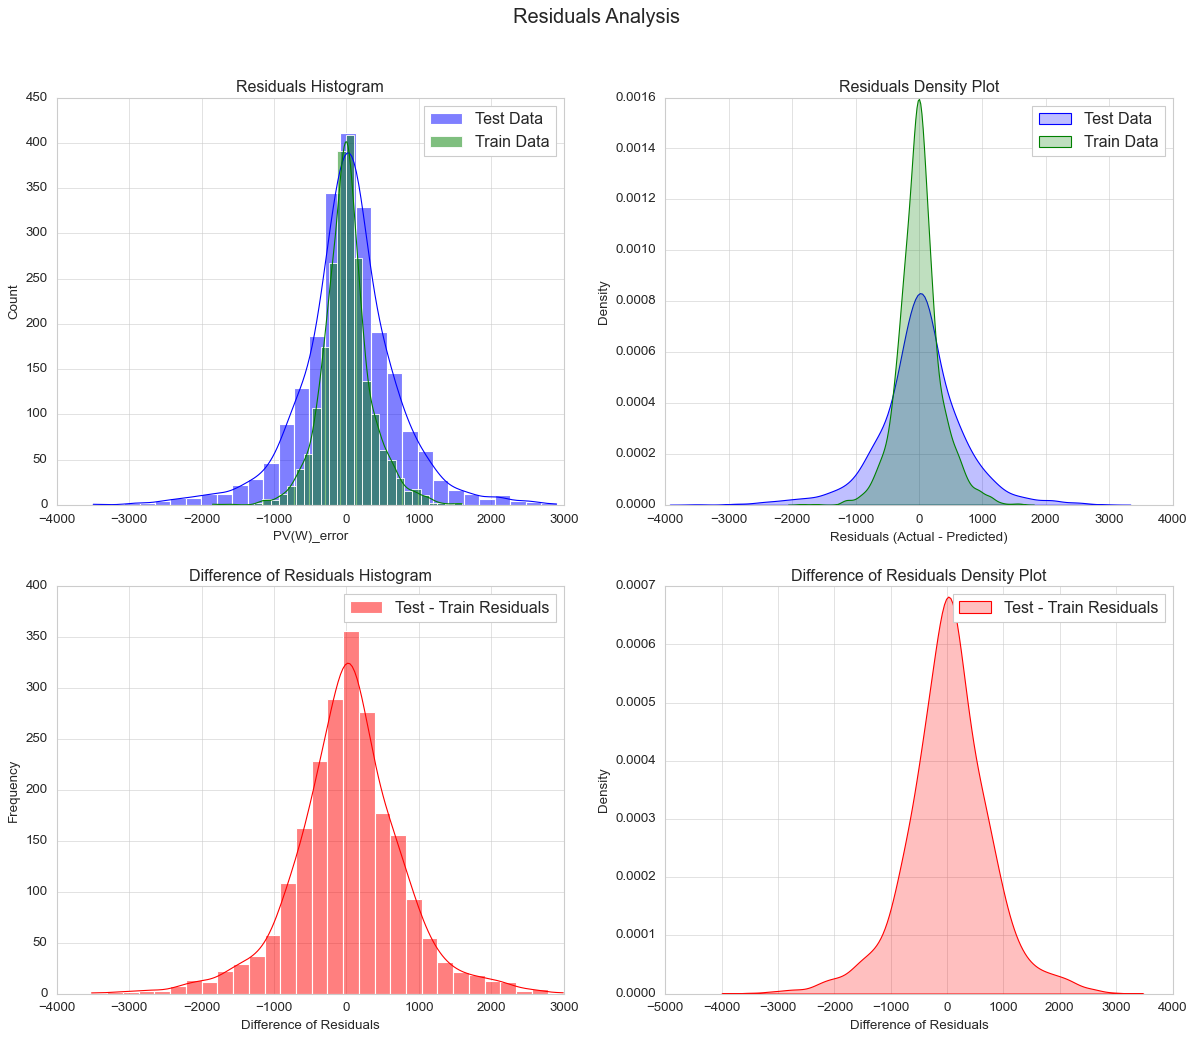

In [288]:
# Residual histogram
def plot_residuals_histogram():
    # Keep the main fig and ax definition
    fig, ax = plt.subplots(2, 2, figsize=(18, 14)) # Slightly taller to prevent title overlap
    ax = ax.flatten()
    fig.suptitle('Residuals Analysis', fontsize=18)
    
    # Subplot 1: Histograms
    sns.histplot(y_test - y_test_pred, color='blue', label='Test Data', kde=True, bins=30, ax=ax[0])
    sns.histplot(y_train - y_train_pred, color='green', label='Train Data', kde=True, bins=30, ax=ax[0])
    ax[0].set_title('Residuals Histogram')
    ax[0].legend() # Added legend here so you can see which is which

    # Subplot 2: Density (Removed the extra plt.figure call)
    sns.kdeplot(y_test - y_test_pred, color='blue', label='Test Data', fill=True, ax=ax[1])
    sns.kdeplot(y_train - y_train_pred, color='green', label='Train Data', fill=True, ax=ax[1])
    ax[1].set_title('Residuals Density Plot')
    ax[1].set_xlabel('Residuals (Actual - Predicted)')
    ax[1].set_ylabel('Density')
    ax[1].legend()
    # plot difference of residuals between train and test as histogram
    sns.histplot((y_test - y_test_pred) - (y_train - y_train_pred), color='red', label='Test - Train Residuals', kde=True, stat="count", bins=30, ax=ax[2])
    ax[2].set_title('Difference of Residuals Histogram')
    ax[2].set_xlabel('Difference of Residuals')
    ax[2].set_ylabel('Frequency')
    ax[2].legend()

    # plot difference of residuals
    sns.kdeplot((y_test - y_test_pred) - (y_train - y_train_pred), color='red', label='Test - Train Residuals', fill=True, ax=ax[3])
    ax[3].set_title('Difference of Residuals Density Plot')
    ax[3].set_xlabel('Difference of Residuals')
    ax[3].set_ylabel('Density')
    ax[3].legend()
    plt.show()


plot_residuals_histogram()

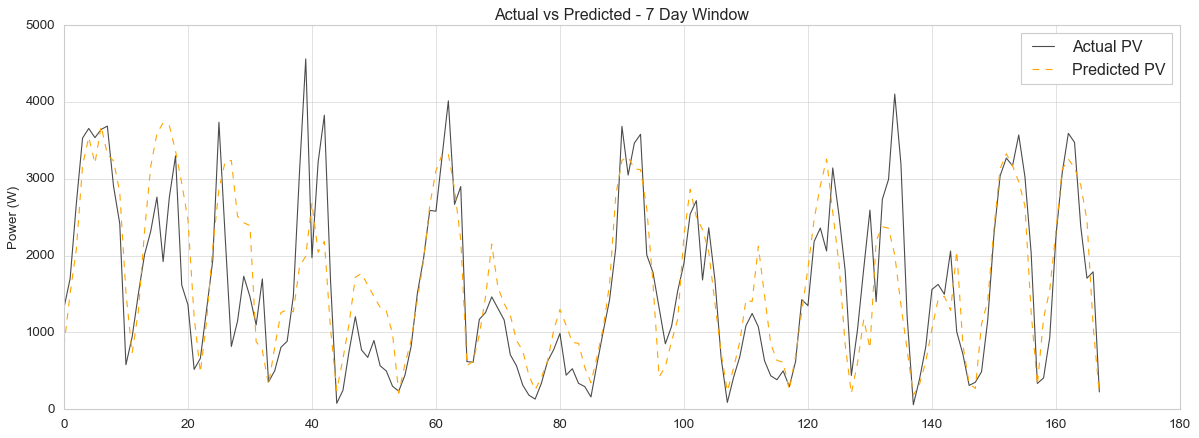

In [289]:
# Create a DataFrame for easy plotting
df_viz = pd.DataFrame({
    'Actual': y_test_pvw,
    'Predicted': y_test_pvw_pred
}).reset_index(drop=True)

# Plot a specific 1-week window (e.g., first 168 hours) to see the daily curve
plt.figure(figsize=(18, 6))
subset = df_viz.iloc[0:168] # First 7 days
plt.plot(subset['Actual'], label='Actual PV', color='black', alpha=0.7)
plt.plot(subset['Predicted'], label='Predicted PV', color='orange', linestyle='--')
plt.title("Actual vs Predicted - 7 Day Window")
plt.ylabel("Power (W)")
plt.legend()
plt.show()

__Error Analysis: Residuals by Hour__   
Does your model consistently under-predict at noon? Or over-predict at sunrise? This plot will tell you.

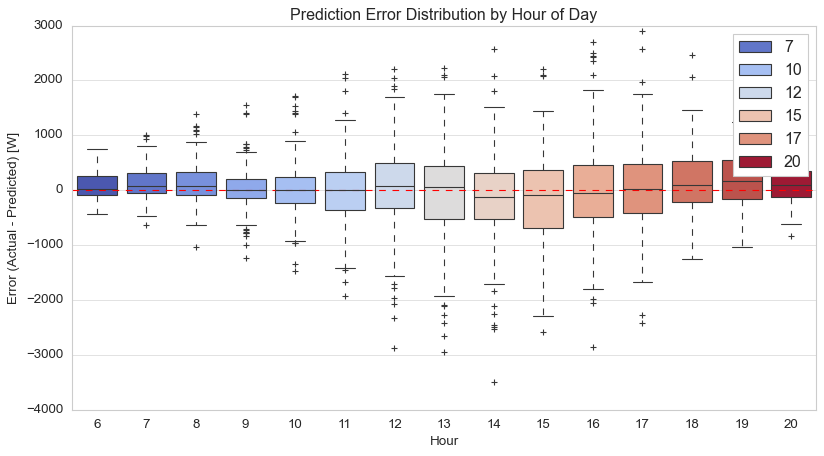

In [290]:
# Extract the residuals
df_results = pd.DataFrame({
    'Actual': y_test_pvw,
    'Predicted': y_test_pvw_pred,
    'Error': y_test_pvw - y_test_pvw_pred,
    'Hour': df_daytime_test.loc[y_test.index, 'Hour']
})

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results, x='Hour', y='Error', palette='coolwarm',hue='Hour', dodge=False)
plt.axhline(0, color='red', linestyle='--')
plt.title('Prediction Error Distribution by Hour of Day')
plt.ylabel('Error (Actual - Predicted) [W]')
plt.legend()
plt.show()

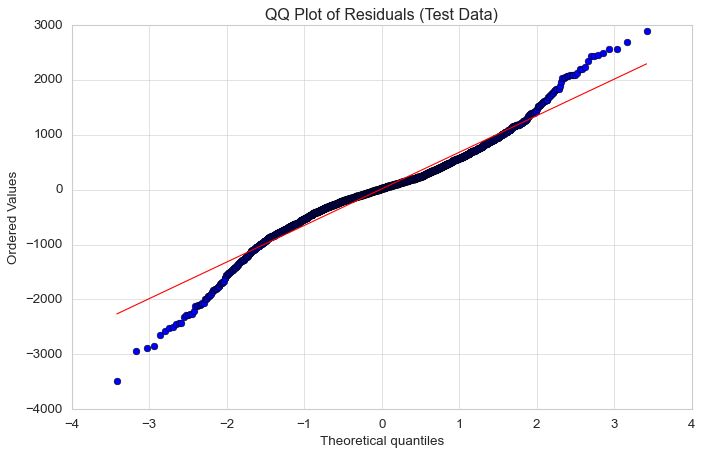

In [291]:
# Add QQ plot for residuals
import scipy.stats as stats
plt.figure(figsize=(10,6))
stats.probplot(y_test - y_test_pred, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals (Test Data)')
plt.show()


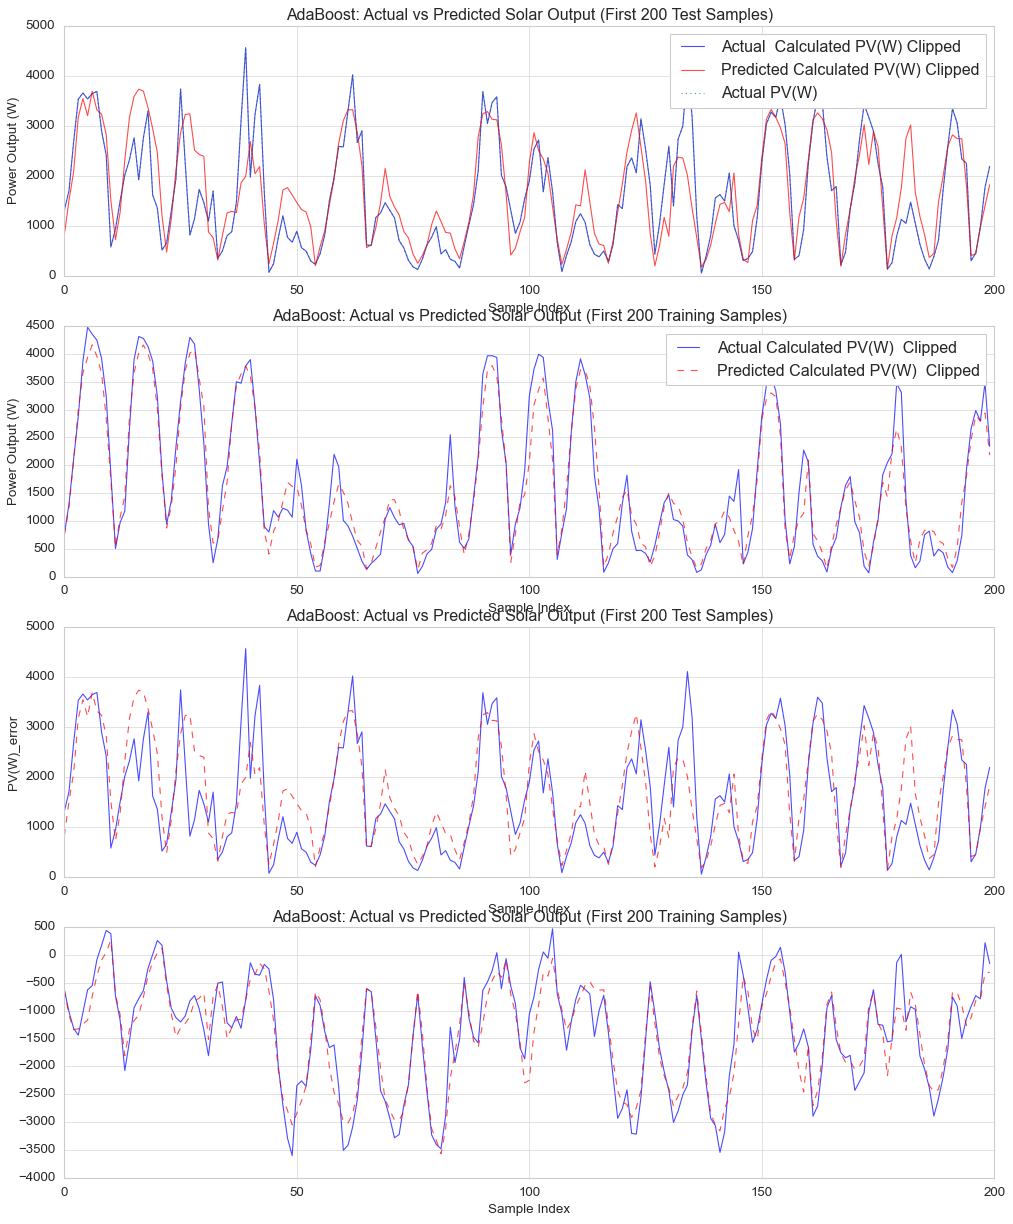

In [292]:
# Plot actual vs predicted for first 200 samples
fig, ax = plt.subplots(4,1,figsize=(15, 18))
ax = ax.flatten()
if target_col == 'PV(W)':
    ax[0].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    # add a gap between test and train plots
    ax[1].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
if target_col == 'Clearsky_Index':
    ax[0].plot(y_test[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot(y_train[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()

    ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel(target_col)
    ax[3].legend()
if target_col == 'PV(W)_error' :
    ax[0].plot((y_test[:200]+ df_daytime_test['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label=f'Actual  Calculated PV(W) Clipped' , color='blue', alpha=0.7)
    ax[0].plot((y_test_pred[:200]+ df_daytime_test['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label='Predicted Calculated PV(W) Clipped', color='red', alpha=0.7)
    ax[0].plot(df_daytime_test['PV(W)'][:200], label='Actual PV(W)', color='green', linestyle=':', alpha=0.7)
    ax[0].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot((y_train[:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label=f'Actual Calculated PV(W)  Clipped', color='blue', alpha=0.7)
    ax[1].plot((y_train_pred[:200]+ df_daytime_train['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label='Predicted Calculated PV(W)  Clipped', color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
    ax[2].plot(y_test_pvw[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pvw_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    #ax[2].legend()
    #ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    #ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    #ax[2].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
    #ax[2].set_xlabel('Sample Index')
    #ax[2].set_ylabel(target_col)
    #ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel        
if target_col == 'PV(W)_error_index':
    ax[0].plot(y_test[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual Calculated PV(W)', color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label='Predicted Calculated PV(W)', color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot(y_train[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual Calculated PV(W)', color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label='Predicted Calculated PV(W)', color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
    ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel

plt.show()

Trying to adjust clear sky by a factor

Write results to CSV file

In [293]:
with open(f'results/adaboost_regressor_hourly_test_metrics.csv', 'a') as f:
    # if this is first line write header
    if os.stat(f'results/adaboost_regressor_hourly_test_metrics.csv').st_size == 0:
        header = ['Model', 'Test No', 'Target Column',
                  'Test Name', 'Test RMSE', 'Test MAE', 'Test R2', 'Test N-RMSE', 'Test N-MAE','Test N-RMSE %', 'Test N-MAE %', 'Test Accuracy',
                  'Train RMSE', 'Train MAE', 'Train R2', 'Train N-RMSE', 'Train N-MAE', 'Train Accuracy','Train N-RMSE %', 'Train N-MAE %', 
                  'Test PV(W) RMSE', 'Test PV(W) MAE', 'Test PV(W) R2', 'Test PV(W) N-RMSE', 'Test PV(W) N-MAE','Test PV(W) N-RMSE %', 'Test PV(W) N-MAE %', 'Test PV(W) Accuracy',
                  'Train PV(W) RMSE', 'Train PV(W) MAE', 'Train PV(W) R2', 'Train PV(W) N-RMSE', 'Train PV(W) N-MAE', 'Train PV(W) Accuracy','Train PV(W) N-RMSE %', 'Train PV(W) N-MAE %',
                  'Notes', 'Feature Columns']
        f.write(','.join(header) + '\n')
    line=[]
    line.append("AdaBoost Regressor Hourly")
    line.append(test_no)
    line.append(test_name)
    line.append(f"{target_col}")
    line.append(f"{test_rmse:.2f}")
    line.append(f"{test_mae:.2f}")
    line.append(f"{test_r2:.4f}")
    line.append(f"{test_n_rmse:.4f}")
    line.append(f"{test_n_mae:.4f}")
    line.append(f"{test_n_rmse*100:.4f}")
    line.append(f"{test_n_mae*100:.4f}")
    line.append(f"{test_accuracy:.4f}")
    line.append(f"{train_rmse:.2f}")
    line.append(f"{train_mae:.2f}")
    line.append(f"{train_r2:.4f}")
    line.append(f"{train_n_rmse:.4f}")
    line.append(f"{train_n_mae:.4f}")
    line.append(f"{train_n_rmse*100:.4f}")
    line.append(f"{train_n_mae*100:.4f}")
    line.append(f"{train_accuracy:.4f}")
    line.append(f"{test_rmse_pvw:.2f}")
    line.append(f"{test_mae_pvw:.2f}")
    line.append(f"{test_r2_pvw:.4f}")
    line.append(f"{test_n_rmse_pvw:.4f}")
    line.append(f"{test_n_mae_pvw:.4f}")
    line.append(f"{test_n_rmse_pvw*100:.4f}")
    line.append(f"{test_n_mae_pvw*100:.4f}")
    line.append(f"{test_accuracy_pvw:.4f}")
    line.append(f"{train_rmse_pvw:.2f}")
    line.append(f"{train_mae_pvw:.2f}")
    line.append(f"{train_r2_pvw:.4f}")
    line.append(f"{train_n_rmse_pvw:.4f}")
    line.append(f"{train_n_mae_pvw:.4f}")
    line.append(f"{train_n_rmse_pvw*100:.4f}")
    line.append(f"{train_n_mae_pvw*100:.4f}")
    line.append(f"{train_accuracy_pvw:.4f}")
    line.append(f"{notes if 'notes' in locals() else ''}")
    line.append(f"feature_cols: {':'.join(feature_cols)}")
    f.write(','.join(line) + '\n')
